**Day 3 - June 7 2022**

| Student                       | ID        |
| -------------                 |:---------:|
| Benjamin Starostka Jakobsen   | s184198   |
| Muhammad REDACTED             | REDACTED  |
| Victor REDACTED               | REDACTED  |

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from scipy import stats

sns.set_style("white")

# Exercise 4
# Discrete simulation/event-by-event

**Write a discrete event simulation program for a blocking system, i.e. a system with $m$ service units and no waiting room. The offered traffic $A$ is the product of the mean arrival rate and the mean service time.**

Erlang’s B-formula:
$$
B = P(m) = \frac{\frac{A^m}{m!}}{\sum_{i=0}^{m}\frac{A^i}{i!}}
$$

with arrival intensity $\lambda$ and mean service time $s$, define $A=\lambda s$

In [ ]:
def ErlangsBFormula(A, m):
    num = A**m / np.math.factorial(m)
    i = np.arange(0, m + 1)
    den = np.sum(A**i / scipy.special.factorial(i))
    B = num / den
    return B

Confidence interval:
$$
\bar{\theta} = \frac{\sum_{i=0}^n\hat{\theta_i}}{n}
$$
$$
S_{\theta}^2 = \frac{1}{n-1}(\sum_{i=0}^n\hat{\theta_i}^2 - n\bar{\theta})
$$
$$
\left[\bar{\theta} + \frac{S_{\theta}}{\sqrt{n}} t_{\frac{\alpha}{2}}\: ; \: \bar{\theta} + \frac{S_{\theta}}{\sqrt{n}} t_{1-\frac{\alpha}{2}} \right]
$$

where $t$ is the quantile from the t-distribution with $n-1$ degrees of freedom.

In [ ]:
def confidence_interval(estimates, perc=0.95):
    estimates = np.array(estimates)
    n = len(estimates)
    mean = np.mean(estimates)
    var = (1 / (n - 1)) * (np.sum(estimates**2) - n * (mean**2))
    std = np.sqrt(var)

    t_lower = stats.t(df=n - 1).ppf((1 - perc) / 2)
    t_upper = stats.t(df=n - 1).ppf(1 - (1 - perc) / 2)

    lower = mean + (std / np.sqrt(n)) * t_lower
    upper = mean + (std / np.sqrt(n)) * t_upper
    return lower, upper

In [ ]:
confidence_intervals = {}


def visualize_results(confidence_inters, truth=None):
    methods_idx = {
        k: i
        for k, i in zip(
            confidence_inters.keys(), np.arange(1, len(confidence_inters) + 1)
        )
    }
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))

    if truth:
        ax.vlines(
            x=truth,
            ymin=0,
            ymax=len(confidence_inters) + 1,
            linestyles="--",
            color="grey",
            label="Truth",
        )

    for method, interval in confidence_inters.items():
        ax.plot(interval, np.full((2,), methods_idx[method]), marker="o", label=method)
    ax.legend()
    ax.set(xlabel="Confidence interval of block ratio", ylabel="Simulation")
    ax.set_yticks([])
    plt.show()

## 1. 
**The arrival process is modelled as a Poisson process. Report the fraction of blocked customers, and a confidence interval for this fraction. Choose the service time distribution as exponential.** 

**Parameters: m = 10, mean service time = 8 time units, mean time between customers = 1 time unit (corresponding to an offered traffic of 8 Erlang), 10 x 10.000 customers.**

**This system is sufficiently simple such that the analytical solution is known. See the last slide for the solution. Verify your simulation program using this knowledge.**

In [ ]:
m = 10
mean_service_time = 8
mean_time_between_customers = 1
n_customers = 10 * 10000

In [ ]:
# Main implementation of the blocking system:
# Given an array of arrival times and an array of service times,
# Simulates a queue of customers with m service units and no waiting room
# Returns the ratio of blocked customers.


def blocking_system(arrival_times, service_times, m, plot=False, prints=False):
    n_customers = len(arrival_times)
    # The m service units each contains as value the time when their current or last job finishes.
    service_units = np.zeros((m,))
    blocks_count = 0
    busy_units_count = np.zeros((n_customers,))
    for i, t in enumerate(arrival_times):
        # Update service units
        empty_units_idx = np.argwhere(service_units <= t).flatten()
        busy_units_count[i] = m - len(empty_units_idx)

        # If at least one unit available, place the customer in the first one
        if len(empty_units_idx) > 0:
            service_units[empty_units_idx[0]] = t + service_times[i]
            busy_units_count[i] += 1

        # Otherwise, all units are busy, block the customer
        else:
            blocks_count += 1

        # Debuging
        if prints and (i % 1000 == 0):
            print(f"{i} Time: {t:.4f} Units: {service_units}")

    if plot:
        fig, ax = plt.subplots(2, 1, figsize=(20, 8))
        ax[0].scatter(arrival_times, service_times, s=1)
        ax[0].set(xlabel="Arrival time", ylabel="Service time")

        ax[1].plot(arrival_times, busy_units_count, linewidth=0.05)
        ax[1].hlines(
            y=m,
            xmin=min(arrival_times),
            xmax=max(arrival_times),
            color="red",
            linewidth=1,
        )
        ax[1].set(xlabel="Arrival time", ylabel="Number of busy units")
        plt.show()

    return blocks_count / n_customers

In [ ]:
# Implementation of the Poisson process for the arrival times
# and the exponential distribution for the service times


def blocking_system_Poisson(
    n_customers,
    m,
    mean_service_time,
    mean_time_between_customers,
    plot=False,
    prints=False,
):

    intervals_between = np.random.exponential(
        scale=mean_time_between_customers, size=n_customers - 1
    )
    arrival_times = np.insert(np.cumsum(intervals_between), 0, 0)

    service_times = np.random.exponential(scale=mean_service_time, size=n_customers)

    return blocking_system(arrival_times, service_times, m, plot=plot, prints=prints)

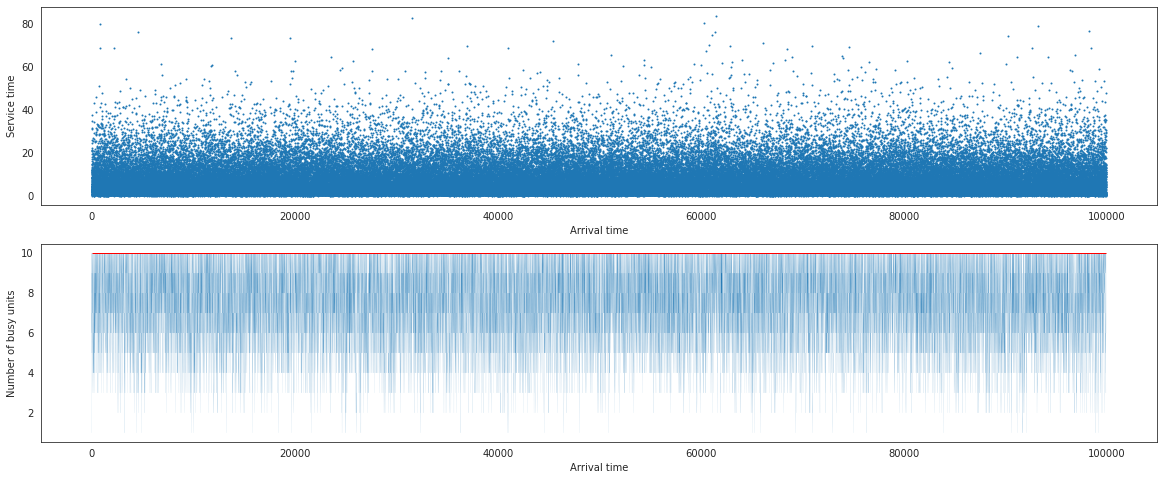

In [ ]:
block_ratio = blocking_system_Poisson(
    n_customers, m, mean_service_time, mean_time_between_customers, plot=True
)

In [ ]:
block_ratio

0.12228

Ratio estimates: [0.1223, 0.12311, 0.12216, 0.12063, 0.12132, 0.12627, 0.11788, 0.11957, 0.12194, 0.12419]
Confidence interval: (0.12025833627044327, 0.12361566372955674)
Erlangs B Formula value: 0.12166106425295149


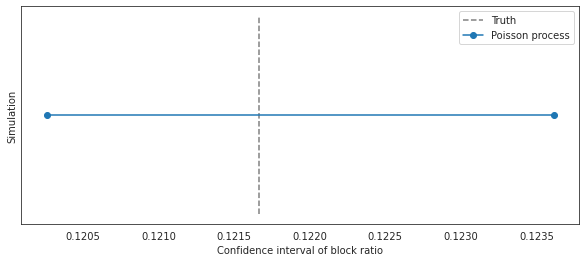

In [ ]:
n_estimates = 10
ratio_estimates = [
    blocking_system_Poisson(
        n_customers, m, mean_service_time, mean_time_between_customers
    )
    for _ in range(n_estimates)
]
confidence_intervals["Poisson process"] = confidence_interval(ratio_estimates)
print("Ratio estimates:", ratio_estimates)
print("Confidence interval:", confidence_intervals["Poisson process"])

A = mean_time_between_customers * mean_service_time
truth = ErlangsBFormula(A, m)
print("Erlangs B Formula value:", truth)

visualize_results(confidence_intervals, truth=truth)

As we can see, the empirical values for the block ratio are roughly equal to the theoretical value computed by Erlang’s B-formula.

## 2.
**The arrival process is modelled as a renewal process using the same parameters as in Part 1 when possible. Report the fraction of blocked customers, and a confidence interval for this fraction for at least the following two cases**

### (a)
**Experiment with Erlang distributed inter arrival times The Erlang distribution should have a mean of 1**

In [ ]:
def blocking_system_Erlang(
    n_customers,
    m,
    mean_service_time,
    mean_time_between_customers,
    plot=False,
    prints=False,
):

    intervals_between = stats.erlang.rvs(
        mean_time_between_customers, size=n_customers - 1
    )
    arrival_times = np.insert(np.cumsum(intervals_between), 0, 0)

    service_times = np.random.exponential(scale=mean_service_time, size=n_customers)

    return blocking_system(arrival_times, service_times, m, plot=plot, prints=prints)

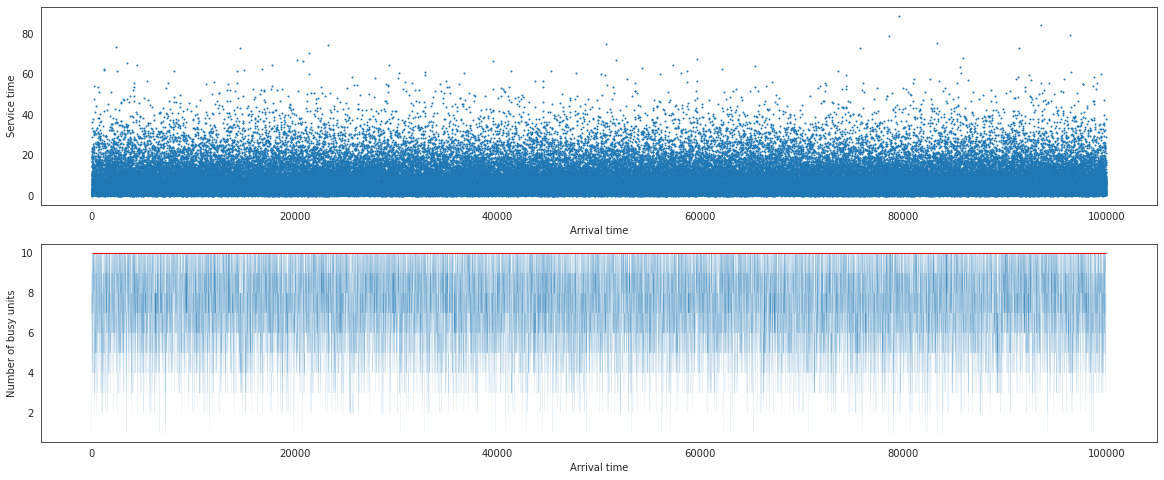

0.12042

In [ ]:
blocking_system_Erlang(
    n_customers, m, mean_service_time, mean_time_between_customers, plot=True
)

Ratio estimates: [0.12256, 0.12048, 0.12511, 0.12559, 0.1216, 0.12086, 0.12121, 0.12246, 0.12024, 0.11936]
Confidence interval: (0.12048642154700269, 0.12340757845299728)


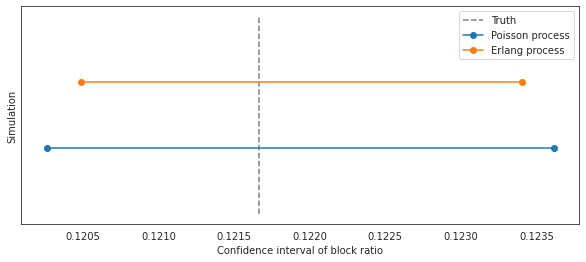

In [ ]:
n_estimates = 10
ratio_estimates = [
    blocking_system_Erlang(
        n_customers, m, mean_service_time, mean_time_between_customers
    )
    for _ in range(n_estimates)
]
confidence_intervals["Erlang process"] = confidence_interval(ratio_estimates)
print("Ratio estimates:", ratio_estimates)
print("Confidence interval:", confidence_intervals["Erlang process"])

visualize_results(confidence_intervals, truth=truth)

Erlang distributed inter arrival times give very similar results than the Poisson process (exponential distributed inter arrival times). 

### (b)
**Hyper exponential inter arrival times. The parameters for the hyper exponential distribution should be
$p_1 = 0.8,\:\:\: \lambda_1 = 0.8333,\:\:\:  p_2 = 0.2,\:\:\:  \lambda_2 = 5.0$.**

In [ ]:
p1 = 0.8
lam1 = 0.8333
p2 = 0.2
lam2 = 5

In [ ]:
def blocking_system_HyperExp(
    n_customers, m, mean_service_time, p1, lam1, p2, lam2, plot=False, prints=False
):

    intervals_between = np.zeros((n_customers - 1,))
    for i in range(n_customers - 1):
        u = np.random.uniform()
        if u < p1:
            x = np.random.exponential(scale=lam1)
        else:
            x = np.random.exponential(scale=lam2)
        intervals_between[i] = x

    arrival_times = np.insert(np.cumsum(intervals_between), 0, 0)

    service_times = np.random.exponential(scale=mean_service_time, size=n_customers)

    return blocking_system(arrival_times, service_times, m, plot=plot, prints=prints)

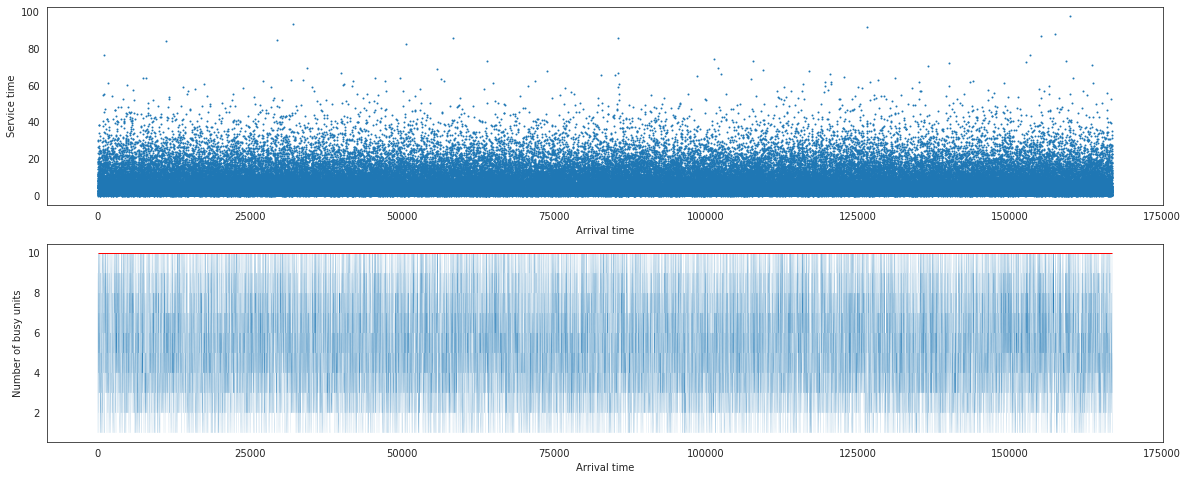

0.05208

In [ ]:
blocking_system_HyperExp(
    n_customers, m, mean_service_time, p1, lam1, p2, lam2, plot=True
)

Ratio estimates: [0.05058, 0.0484, 0.04917, 0.05173, 0.04858, 0.05094, 0.04758, 0.04846, 0.04811, 0.04722]
Confidence interval: (0.04799769286322981, 0.05015630713677018)


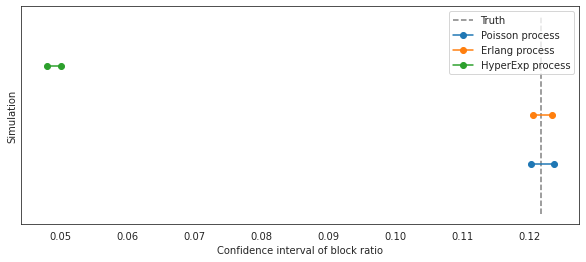

In [ ]:
n_estimates = 10
ratio_estimates = [
    blocking_system_HyperExp(n_customers, m, mean_service_time, p1, lam1, p2, lam2)
    for _ in range(n_estimates)
]
confidence_intervals["HyperExp process"] = confidence_interval(ratio_estimates)
print("Ratio estimates:", ratio_estimates)
print("Confidence interval:", confidence_intervals["HyperExp process"])

visualize_results(confidence_intervals, truth=truth)

Hyper exponential inter arrival times give a very different block ratio of customers than the two previous experiment. A lot less customers are being blocked. We explain that due to $\lambda_2=5$ for 20% of the in-between customer times. This would result in a break in the arrival of customers large enough for service unit to finish their job and thus being free and not rejecting customers.

## 3.
**The arrival process is again a Poisson process like in Part 1. Experiment with different service time distributions with the same mean service time and $m$ as in Part 1 and Part 2.**

### (a)
**Constant service time**

In [ ]:
def blocking_system_Poisson_constant(
    n_customers,
    m,
    cst_service_time,
    mean_time_between_customers,
    plot=False,
    prints=False,
):

    intervals_between = np.random.exponential(
        scale=mean_time_between_customers, size=n_customers - 1
    )
    arrival_times = np.insert(np.cumsum(intervals_between), 0, 0)

    service_times = np.ones((n_customers,)) * cst_service_time

    return blocking_system(arrival_times, service_times, m, plot=plot, prints=prints)

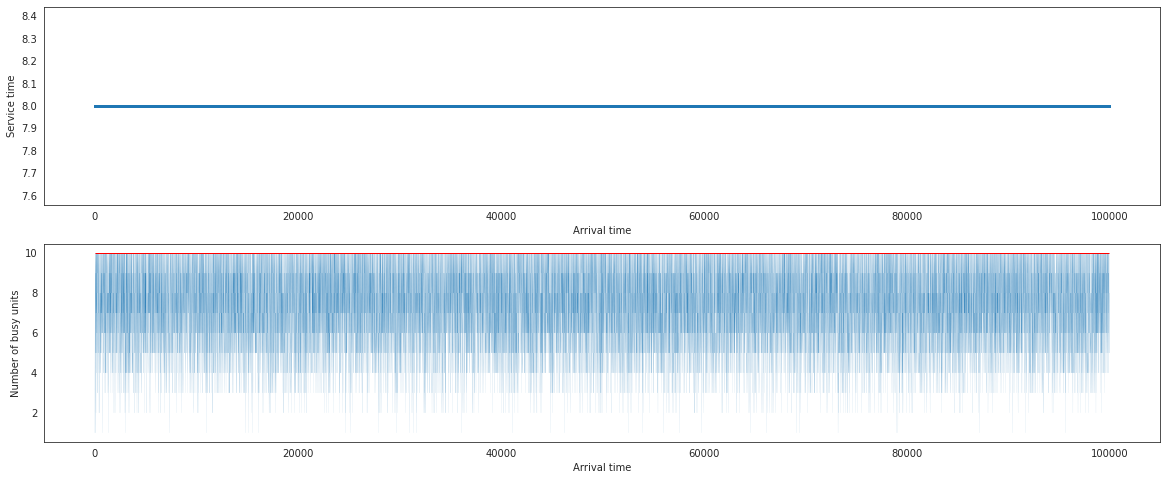

0.11917

In [ ]:
cst_service_time = 8
blocking_system_Poisson_constant(
    n_customers, m, cst_service_time, mean_time_between_customers, plot=True
)

Ratio estimates: [0.12118, 0.12235, 0.12071, 0.12202, 0.12112, 0.12231, 0.12246, 0.12014, 0.12065, 0.12564]
Confidence interval: (0.12074282917324165, 0.12297317082675834)


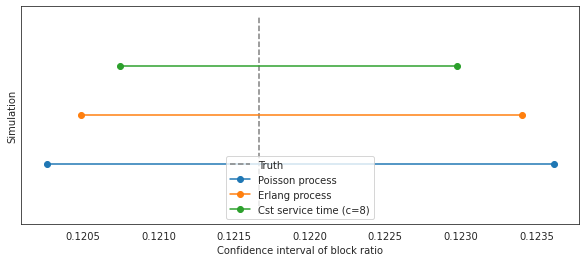

In [ ]:
n_estimates = 10
ratio_estimates = [
    blocking_system_Poisson_constant(
        n_customers, m, cst_service_time, mean_time_between_customers
    )
    for _ in range(n_estimates)
]
confidence_intervals[f"Cst service time (c={cst_service_time})"] = confidence_interval(
    ratio_estimates
)
print("Ratio estimates:", ratio_estimates)
print(
    "Confidence interval:",
    confidence_intervals[f"Cst service time (c={cst_service_time})"],
)

visualize_results(
    {
        k: confidence_intervals[k]
        for k in ["Poisson process", "Erlang process", "Cst service time (c=8)"]
    },
    truth=truth,
)

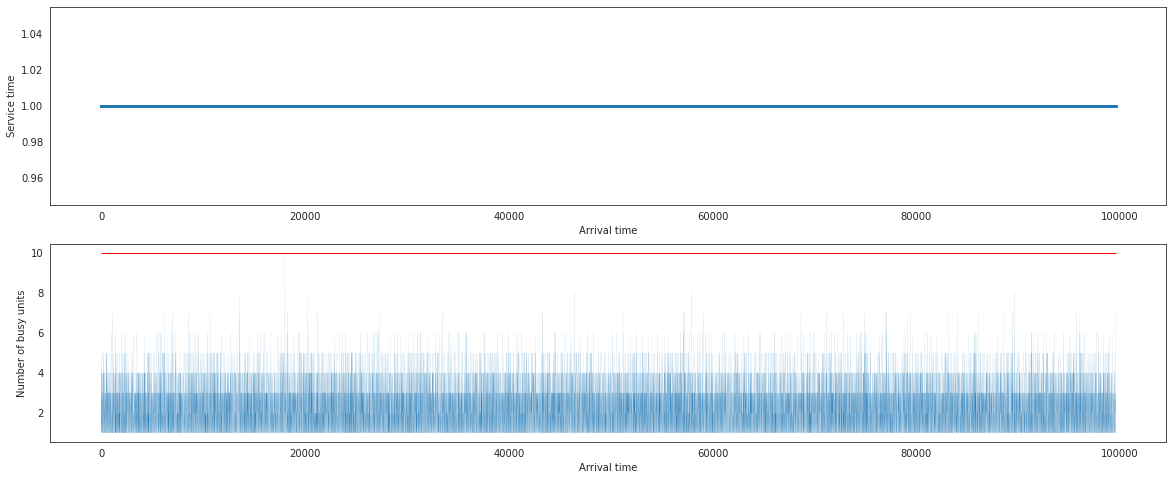

0.0

In [ ]:
cst_service_time = 1
blocking_system_Poisson_constant(
    n_customers, m, cst_service_time, mean_time_between_customers, plot=True
)

In [ ]:
n_estimates = 10
ratio_estimates = [
    blocking_system_Poisson_constant(
        n_customers, m, cst_service_time, mean_time_between_customers
    )
    for _ in range(n_estimates)
]
confidence_intervals_cst = {}
confidence_intervals_cst[
    f"Cst service time (c={cst_service_time})"
] = confidence_interval(ratio_estimates)
print("Ratio estimates:", ratio_estimates)
print(
    "Confidence interval:",
    confidence_intervals_cst[f"Cst service time (c={cst_service_time})"],
)

Ratio estimates: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Confidence interval: (0.0, 0.0)


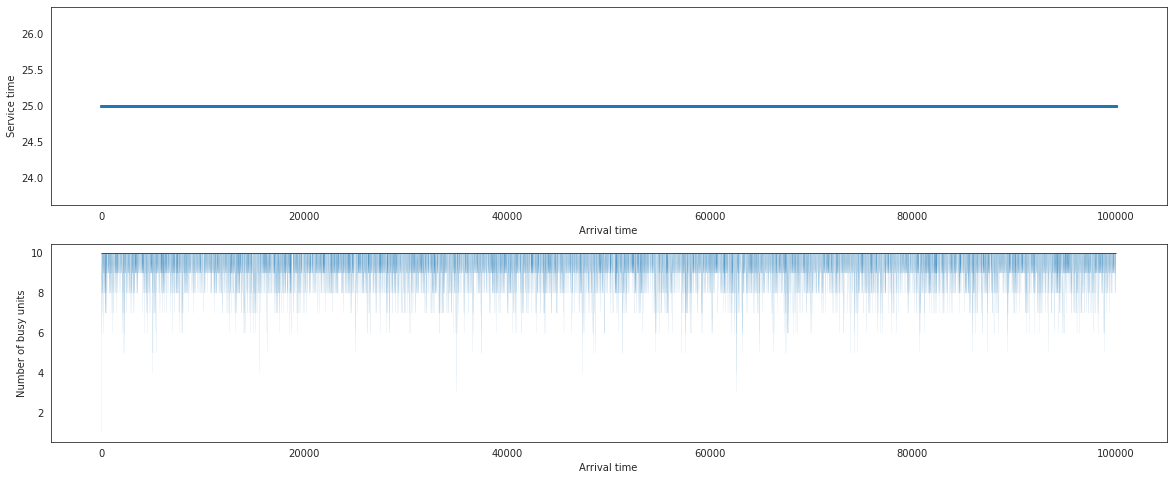

0.62233

In [ ]:
cst_service_time = 25
blocking_system_Poisson_constant(
    n_customers, m, cst_service_time, mean_time_between_customers, plot=True
)

In [ ]:
n_estimates = 10
ratio_estimates = [
    blocking_system_Poisson_constant(
        n_customers, m, cst_service_time, mean_time_between_customers
    )
    for _ in range(n_estimates)
]
confidence_intervals_cst[
    f"Cst service time (c={cst_service_time})"
] = confidence_interval(ratio_estimates)
print("Ratio estimates:", ratio_estimates)
print(
    "Confidence interval:",
    confidence_intervals_cst[f"Cst service time (c={cst_service_time})"],
)

Ratio estimates: [0.62187, 0.62281, 0.6219, 0.62155, 0.62313, 0.62314, 0.62165, 0.62321, 0.62247, 0.62244]
Confidence interval: (0.6219568296840414, 0.6228771703159586)


### (b)
**Pareto distributed service times with at least $k = 1.05$ and $k = 2.05$.**

In [ ]:
def blocking_system_Poisson_Pareto(
    n_customers, m, k, mean_time_between_customers, plot=False, prints=False
):

    intervals_between = np.random.exponential(
        scale=mean_time_between_customers, size=n_customers - 1
    )
    arrival_times = np.insert(np.cumsum(intervals_between), 0, 0)

    service_times = stats.pareto.rvs(b=k, size=n_customers)

    return blocking_system(arrival_times, service_times, m, plot=plot, prints=prints)

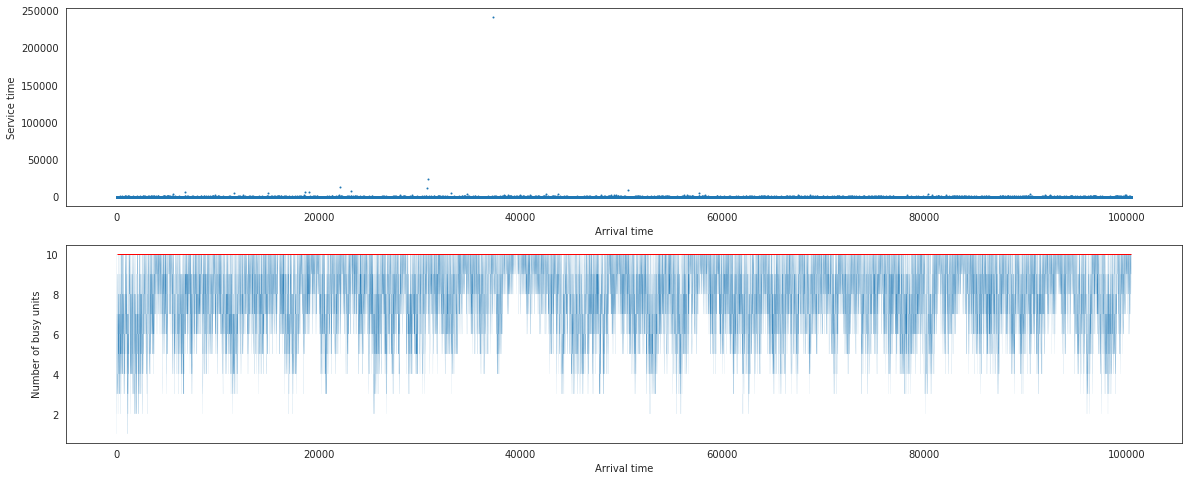

0.1462

In [ ]:
k = 1.05
blocking_system_Poisson_Pareto(
    n_customers, m, k, mean_time_between_customers, plot=True
)

In [ ]:
n_estimates = 10
ratio_estimates = [
    blocking_system_Poisson_Pareto(n_customers, m, k, mean_time_between_customers)
    for _ in range(n_estimates)
]
lower, upper = confidence_interval(ratio_estimates)
print(ratio_estimates)
print(lower, upper)

[0.14715, 0.13472, 0.143, 0.12859, 0.2286, 0.19795, 0.18968, 0.15108, 0.11467, 0.15181]
0.13338609184298697 0.18406390815701304


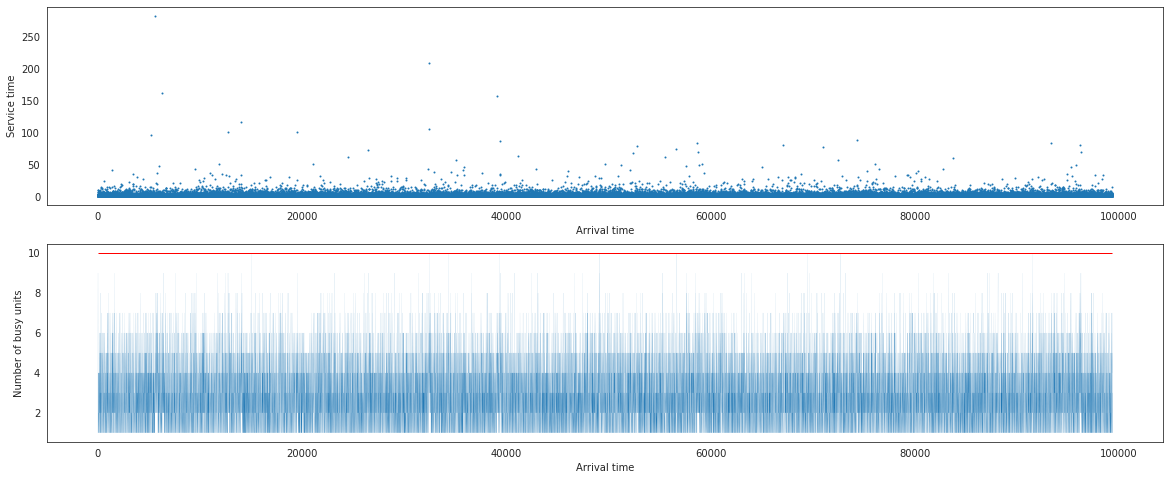

1e-05

In [ ]:
k = 2.05
blocking_system_Poisson_Pareto(
    n_customers, m, k, mean_time_between_customers, plot=True
)

In [ ]:
n_estimates = 10
ratio_estimates = [
    blocking_system_Poisson_Pareto(n_customers, m, k, mean_time_between_customers)
    for _ in range(n_estimates)
]
lower, upper = confidence_interval(ratio_estimates)
print(ratio_estimates)
print(lower, upper)

[1e-05, 4e-05, 0.0, 1e-05, 2e-05, 3e-05, 2e-05, 2e-05, 8e-05, 2e-05]
9.09324745804661e-06 4.090675254195339e-05


### (c)
**Choose one or two other distributions.**

**1. Uniform distribution for service time:**

In [ ]:
def blocking_system_Poisson_Uniform(
    n_customers, m, a, b, mean_time_between_customers, plot=False, prints=False
):

    intervals_between = np.random.exponential(
        scale=mean_time_between_customers, size=n_customers - 1
    )
    arrival_times = np.insert(np.cumsum(intervals_between), 0, 0)

    service_times = np.random.uniform(a, b, size=n_customers)

    return blocking_system(arrival_times, service_times, m, plot=plot, prints=prints)

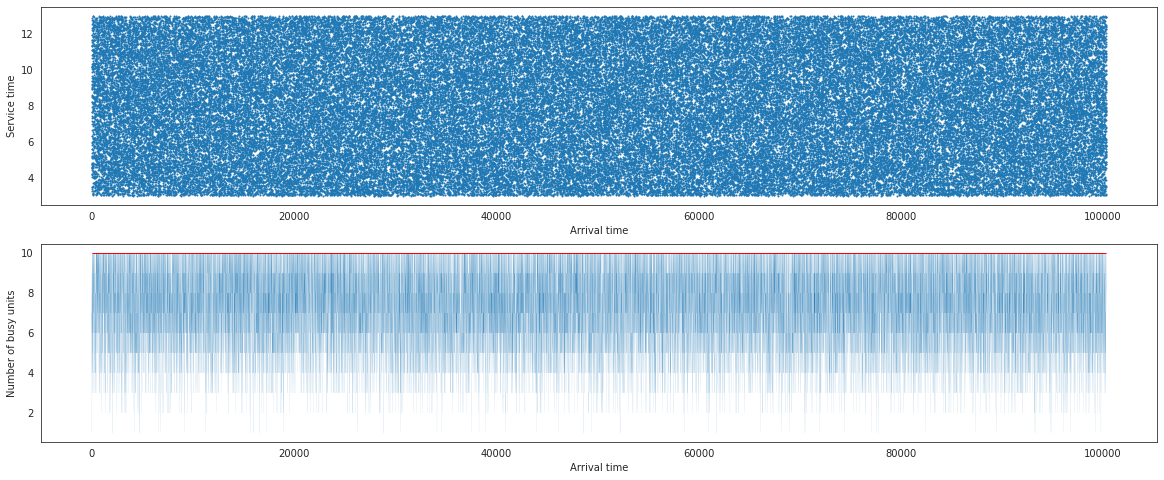

0.12094

In [ ]:
a = 3
b = 13
blocking_system_Poisson_Uniform(
    n_customers, m, a, b, mean_time_between_customers, plot=True
)

Ratio estimates: [0.12197, 0.12107, 0.12245, 0.11988, 0.11921, 0.12258, 0.12083, 0.12108, 0.12122, 0.122]
Confidence interval: (0.12045403038539997, 0.12200396961460001)


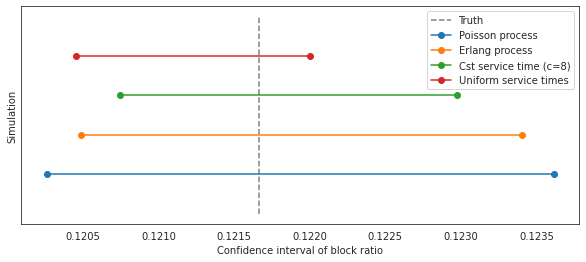

In [ ]:
n_estimates = 10
ratio_estimates = [
    blocking_system_Poisson_Uniform(n_customers, m, a, b, mean_time_between_customers)
    for _ in range(n_estimates)
]
confidence_intervals["Uniform service times"] = confidence_interval(ratio_estimates)
print("Ratio estimates:", ratio_estimates)
print("Confidence interval:", confidence_intervals["Uniform service times"])

visualize_results(
    {
        k: confidence_intervals[k]
        for k in [
            "Poisson process",
            "Erlang process",
            "Cst service time (c=8)",
            "Uniform service times",
        ]
    },
    truth=truth,
)

The uniformly distributed service times ($\sim U[3, 13]$) (and Poisson process for the arrival times) give similar results than the two first experiments with exponentially distributed service times ($\sim\exp(8)$).
We think that this is because we purposefully chose the mean of the uniform distribution to be equal to the mean of the exponential distribution.

**2. $\chi^2$ distribution for service time:**

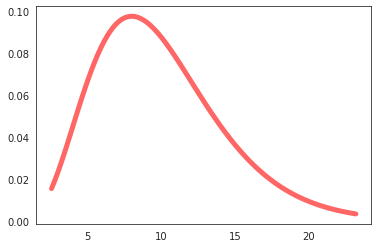

In [ ]:
k = 10
fig, ax = plt.subplots()
x = np.linspace(stats.chi2.ppf(0.01, k), stats.chi2.ppf(0.99, k), 100)
ax.plot(x, stats.chi2.pdf(x, k), "r-", lw=5, alpha=0.6, label="chi2 pdf")
plt.show()

In [ ]:
def blocking_system_Poisson_Chi(
    n_customers, m, k, mean_time_between_customers, plot=False, prints=False
):

    intervals_between = np.random.exponential(
        scale=mean_time_between_customers, size=n_customers - 1
    )
    arrival_times = np.insert(np.cumsum(intervals_between), 0, 0)

    service_times = stats.chi2.rvs(k, size=n_customers)

    return blocking_system(arrival_times, service_times, m, plot=plot, prints=prints)

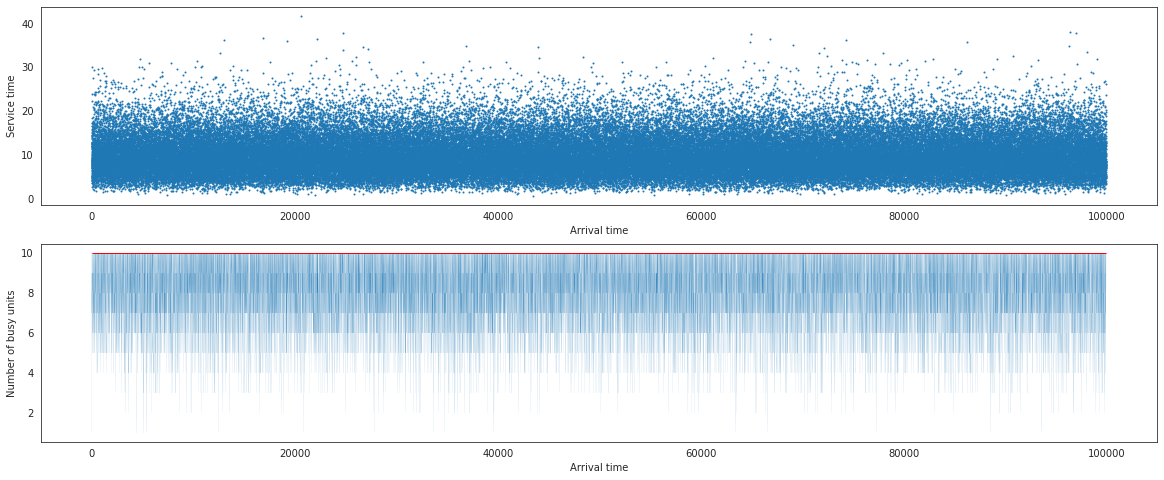

0.21562

In [ ]:
blocking_system_Poisson_Chi(n_customers, m, k, mean_time_between_customers, plot=True)

In [ ]:
n_estimates = 10
ratio_estimates = [
    blocking_system_Poisson_Chi(n_customers, m, k, mean_time_between_customers)
    for _ in range(n_estimates)
]
lower, upper = confidence_interval(ratio_estimates)
print(ratio_estimates)
print(lower, upper)

[0.21205, 0.21677, 0.2128, 0.21693, 0.2153, 0.21134, 0.21149, 0.21597, 0.21766, 0.21174]
0.21238072534280017 0.2160292746571998


## 4.
**Compare confidence intervals for Parts 1, 2, and 3 then interpret and explain differences if any.**

Taking the Poisson process in Part 1 as our baseline, we see that the 95% confidence interval contains the truth value, i.e. analytical solution, computed with Erlang's B-formula.


In Part 2 a), with Erlang distributed arrival times, we see that the confidence interval is very similar to the Poisson one in Part 1. 

In Part 2 b), with Hyper Exponential distributed arrival times the values for the confidence interval are much smaller. This is because for 20% of the time the gap between two consecutive customers is very large resulting in service units being free thus decreasing the block ratio.  

Part 3), changing the service times can vastly change the estimated block ratio. Constant service times of 8 give similar result than Part 1, where the mean service time is also 8. Same observation for uniformly distributed service times with mean 8. Pareto distributed services times shows the effect of outliers with extremely large service times, the effect of these outlier customers is comparable to a service unit shutting down.